In [11]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [12]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [13]:
from ast import literal_eval
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from matplotlib.colors import LinearSegmentedColormap, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# for html to png
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options

from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS
from SSMuLA.vis_summary import ZS_METRICS
from SSMuLA.get_corr import LANDSCAPE_ATTRIBUTES, val_list, zs_list
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, save_plt
from SSMuLA.util import checkNgen_folder


import os
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np

from ast import literal_eval

from scipy.stats import spearmanr

import bokeh
from bokeh.io import show, export_svg, export_png, output_notebook
from bokeh.plotting import show, figure
from bokeh.themes.theme import Theme


import holoviews as hv
from holoviews import opts, dim

from SSMuLA.landscape_global import get_file_name, n_mut_cutoff_dict
from SSMuLA.de_simulations import DE_TYPES
from SSMuLA.zs_analysis import ZS_OPTS, ZS_COMB_OPTS, ZS_OPTS_LEGEND
from SSMuLA.vis_summary import N_SAMPLE_LIST, N_MUT_SUBS, ZS_METRICS, ZS_N_MUTS
from SSMuLA.vis import LIB_COLORS, save_bokeh_hv
from SSMuLA.util import checkNgen_folder



# Custom colormap for the MSE row, using greens
cmap_mse = LinearSegmentedColormap.from_list(
    "mse_cmap_r", ["#FFFFFF", "#9bbb59"][::-1], N=100
)  # dark to light green

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list(
    "bwg",
    [
        PRESENTATION_PALETTE_SATURATE["blue"],
        "white",
        PRESENTATION_PALETTE_SATURATE["green"],
    ],
    N=100,
)

custom_cmap_r = LinearSegmentedColormap.from_list(
    "bwg_r",
    [
        sns.dark_palette("seagreen").as_hex()[-1],
        "white",
        sns.color_palette("Blues").as_hex()[-1],
    ],
    N=100,
)

de_metrics = ["mean_all", "fraction_max"]

simple_des = {
    "recomb_SSM": "Recomb",
    "single_step_DE": "Single step",
    "top96_SSM": "Top96 recomb",
}

In [14]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]

In [15]:
zs_csv = "results/zs_sum_2/min0/zs_stat_scale2max.csv"

In [16]:
zs_df = pd.read_csv(zs_csv)
n_mut = "all"

zs_df_list = [zs_df[["lib", "n_mut"]]]
# Create new columns for each score type
for c in ZS_OPTS + ZS_COMB_OPTS:

    zs_name = c.replace("_score", "")
    zs_df_list.append(
        zs_df[f"{zs_name}_score"]
        .str.replace(": nan", ": None")
        .apply(literal_eval)
        .apply(pd.Series)
        .rename(columns={m: f"{zs_name}_{m}" for m in ZS_METRICS})
    )

zs_df_expend = pd.concat(zs_df_list, axis=1)

zs_mut_df_list = [zs_df_expend[zs_df_expend["n_mut"] == n_mut]["lib"]]
for n_mut in ZS_N_MUTS:
    slice_df = (
        zs_df_expend[zs_df_expend["n_mut"] == n_mut]
        .drop(columns=["lib", "n_mut"])
        .reset_index(drop=True)
    )
    zs_mut_df_list.append(
        slice_df.rename(columns={c: f"{n_mut}_{c}" for c in slice_df.columns})
    )
zs_df = pd.concat(zs_mut_df_list, axis=1)
zs_df

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_struc-comb_rocauc,single_msanoif-comb_rho,single_msanoif-comb_ndcg,single_msanoif-comb_rocauc,single_msa-comb_rho,single_msa-comb_ndcg,single_msa-comb_rocauc,single_structnmsa-comb_rho,single_structnmsa-comb_ndcg,single_structnmsa-comb_rocauc
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.304167,0.583005,0.891175,0.917361,0.553279,0.891577,0.911111,-0.212895,0.800908,0.320833
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.916196,0.260675,0.686378,0.588512,0.774073,0.784778,0.897363,0.811746,0.786033,0.916196
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.964912,0.579624,0.969377,0.842105,0.676766,0.976464,0.947368,0.687594,0.988024,0.964912
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,NaN,0.321146,0.993785,NaN,0.369282,0.995510,NaN,0.337783,0.993260,NaN
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.622685,0.505150,0.887328,0.862269,0.490425,0.892182,0.850694,0.097446,0.525140,0.646991
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.759259,0.361793,0.914430,0.975309,0.373545,0.924416,0.981481,0.155952,0.795325,0.796296
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,1.000000,0.264137,0.873296,0.981818,0.380206,0.942209,1.000000,0.336462,0.934191,0.996970
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.672457,0.497656,0.875823,0.745658,0.408905,0.854952,0.682382,0.386136,0.814950,0.699132
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.401722,0.718998,0.938319,0.991392,0.692477,0.914564,0.958393,-0.076301,0.511023,0.467719
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.720844,0.446829,0.872552,0.617246,0.375107,0.868215,0.634615,0.500940,0.903963,0.714640


In [17]:
active_lib_list = ['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [18]:
zs_df["type"] = zs_df["lib"].map(
    {n: v["type"] for n, v in LIB_INFO_DICT.items()}
)
zs_df

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_msanoif-comb_rho,single_msanoif-comb_ndcg,single_msanoif-comb_rocauc,single_msa-comb_rho,single_msa-comb_ndcg,single_msa-comb_rocauc,single_structnmsa-comb_rho,single_structnmsa-comb_ndcg,single_structnmsa-comb_rocauc,type
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.583005,0.891175,0.917361,0.553279,0.891577,0.911111,-0.212895,0.800908,0.320833,Enzymatic activity
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.260675,0.686378,0.588512,0.774073,0.784778,0.897363,0.811746,0.786033,0.916196,Binding
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.579624,0.969377,0.842105,0.676766,0.976464,0.947368,0.687594,0.988024,0.964912,Binding
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,0.321146,0.993785,NaN,0.369282,0.995510,NaN,0.337783,0.993260,NaN,Binding
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.505150,0.887328,0.862269,0.490425,0.892182,0.850694,0.097446,0.525140,0.646991,Enzymatic activity
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.361793,0.914430,0.975309,0.373545,0.924416,0.981481,0.155952,0.795325,0.796296,Enzymatic activity
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,0.264137,0.873296,0.981818,0.380206,0.942209,1.000000,0.336462,0.934191,0.996970,Enzymatic activity
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.497656,0.875823,0.745658,0.408905,0.854952,0.682382,0.386136,0.814950,0.699132,Enzymatic activity
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.718998,0.938319,0.991392,0.692477,0.914564,0.958393,-0.076301,0.511023,0.467719,Enzymatic activity
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.446829,0.872552,0.617246,0.375107,0.868215,0.634615,0.500940,0.903963,0.714640,Enzymatic activity


In [19]:
slice_zs = zs_df[zs_df["lib"].isin(active_lib_list)]
zs_cols = ["all_" + zs.replace("score", "rho") for zs in ZS_OPTS]
zs_rocauc_cols = ["all_" + zs.replace("score", "rocauc") for zs in ZS_OPTS]

In [20]:
binding = slice_zs[slice_zs["type"] == "Binding"]
ea = slice_zs[slice_zs["type"] == "Enzymatic activity"]

In [21]:
slice_zs[zs_cols].mean(axis=0), binding[zs_cols].mean(axis=0), ea[zs_cols].mean(axis=0)

(all_ed_rho       0.190650
 all_Triad_rho    0.160620
 all_ev_rho       0.257969
 all_esm_rho      0.257452
 all_esmif_rho    0.259739
 dtype: float64,
 all_ed_rho       0.299692
 all_Triad_rho    0.266718
 all_ev_rho       0.363444
 all_esm_rho      0.390565
 all_esmif_rho    0.480481
 dtype: float64,
 all_ed_rho       0.143918
 all_Triad_rho    0.115150
 all_ev_rho       0.212765
 all_esm_rho      0.200403
 all_esmif_rho    0.165136
 dtype: float64)

In [22]:
slice_zs[zs_rocauc_cols].mean(axis=0), binding[zs_rocauc_cols].mean(axis=0), ea[zs_rocauc_cols].mean(axis=0)

(all_ed_rocauc       0.636173
 all_Triad_rocauc    0.707701
 all_ev_rocauc       0.756567
 all_esm_rocauc      0.737771
 all_esmif_rocauc    0.773699
 dtype: float64,
 all_ed_rocauc       0.564884
 all_Triad_rocauc    0.757978
 all_ev_rocauc       0.665740
 all_esm_rocauc      0.671912
 all_esmif_rocauc    0.785210
 dtype: float64,
 all_ed_rocauc       0.666725
 all_Triad_rocauc    0.686154
 all_ev_rocauc       0.795493
 all_esm_rocauc      0.765996
 all_esmif_rocauc    0.768766
 dtype: float64)

In [23]:
for n in N_SAMPLE_LIST:
    merge_csv = f"results/corr_all/{str(n)}/boosting|ridge-top96/actcut-1/merge_all.csv"
    merge_df = pd.read_csv(merge_csv)
    

In [24]:
%matplotlib inline

In [25]:
from SSMuLA.landscape_global import LIB_TYPES

In [26]:
from SSMuLA.zs_analysis import ZS_OPTS_LEGEND

In [27]:
from matplotlib.lines import Line2D

In [28]:
# get msa factors
from SSMuLA.zs_data import EV_META

In [29]:
EV_META.keys()

dict_keys(['DHFR', 'ParD2', 'ParD3', 'GB1', 'TrpB'])

In [30]:
get_msa_dict = {}

for l, v in EV_META.items():
    if l != "TrpB":
        if "chosen" in v.keys():
            get_msa_dict[l] = v["chosen"]["sequences"]
        else:
            get_msa_dict[l] = v["recommended"]["sequences"]
    else:
        ls = [l+ "3"+ app for app in [chr(i) for i in range(ord('A'), ord('I')+1)]]+ ["TrpB4"]
        for t in ls:
            if "chosen" in v.keys():
                get_msa_dict[t] = v["chosen"]["sequences"]
            else:
                get_msa_dict[t] = v["recommended"]["sequences"]

In [31]:
get_msa_dict

{'DHFR': 16042,
 'ParD2': 6789,
 'ParD3': 6784,
 'GB1': 29,
 'TrpB3A': 5816,
 'TrpB3B': 5816,
 'TrpB3C': 5816,
 'TrpB3D': 5816,
 'TrpB3E': 5816,
 'TrpB3F': 5816,
 'TrpB3G': 5816,
 'TrpB3H': 5816,
 'TrpB3I': 5816,
 'TrpB4': 5816}

In [32]:
msa_df = pd.DataFrame(get_msa_dict, index=["MSA"]).T.reset_index()
msa_df.columns=["lib", "msa"]
msa_df

,lib,msa
0,DHFR,16042
1,ParD2,6789
2,ParD3,6784
3,GB1,29
4,TrpB3A,5816
5,TrpB3B,5816
6,TrpB3C,5816
7,TrpB3D,5816
8,TrpB3E,5816
9,TrpB3F,5816


In [33]:
zs_append_msa = pd.merge(zs_df, msa_df, on="lib")
zs_append_msa

,lib,all_ed_rho,all_ed_ndcg,all_ed_rocauc,all_Triad_rho,all_Triad_ndcg,all_Triad_rocauc,all_ev_rho,all_ev_ndcg,all_ev_rocauc,...,single_msanoif-comb_ndcg,single_msanoif-comb_rocauc,single_msa-comb_rho,single_msa-comb_ndcg,single_msa-comb_rocauc,single_structnmsa-comb_rho,single_structnmsa-comb_ndcg,single_structnmsa-comb_rocauc,type,msa
0,DHFR,0.251154,0.914803,0.719973,0.017801,0.874707,0.452238,0.339650,0.947058,0.912765,...,0.891175,0.917361,0.553279,0.891577,0.911111,-0.212895,0.800908,0.320833,Enzymatic activity,16042
1,GB1,0.144928,0.687396,0.577572,0.288282,0.764049,0.715632,0.189509,0.721558,0.627690,...,0.686378,0.588512,0.774073,0.784778,0.897363,0.811746,0.786033,0.916196,Binding,29
2,ParD2,0.297520,0.902898,0.552103,0.227370,0.843746,0.652049,0.440248,0.915307,0.664011,...,0.969377,0.842105,0.676766,0.976464,0.947368,0.687594,0.988024,0.964912,Binding,6789
3,ParD3,0.456627,0.953525,0.564976,0.284501,0.886169,0.906254,0.460576,0.955882,0.705520,...,0.993785,NaN,0.369282,0.995510,NaN,0.337783,0.993260,NaN,Binding,6784
4,TrpB3A,0.146519,0.672480,0.608694,-0.016552,0.488693,0.664616,0.105892,0.743685,0.657328,...,0.887328,0.862269,0.490425,0.892182,0.850694,0.097446,0.525140,0.646991,Enzymatic activity,5816
5,TrpB3B,0.048451,0.638318,0.551217,0.041425,0.348852,0.653659,0.056590,0.672504,0.583225,...,0.914430,0.975309,0.373545,0.924416,0.981481,0.155952,0.795325,0.796296,Enzymatic activity,5816
6,TrpB3C,0.055999,0.646208,0.605496,0.043581,0.680187,0.621564,0.050793,0.660263,0.539872,...,0.873296,0.981818,0.380206,0.942209,1.000000,0.336462,0.934191,0.996970,Enzymatic activity,5816
7,TrpB3D,0.119253,0.750375,0.609910,0.213946,0.761741,0.751696,0.233182,0.822937,0.785684,...,0.875823,0.745658,0.408905,0.854952,0.682382,0.386136,0.814950,0.699132,Enzymatic activity,5816
8,TrpB3E,0.013191,0.728204,0.563633,-0.017332,0.593711,0.504706,0.017571,0.852058,0.515337,...,0.938319,0.991392,0.692477,0.914564,0.958393,-0.076301,0.511023,0.467719,Enzymatic activity,5816
9,TrpB3F,0.209446,0.763770,0.865507,0.093448,0.688977,0.865511,0.103260,0.804297,0.873863,...,0.872552,0.617246,0.375107,0.868215,0.634615,0.500940,0.903963,0.714640,Enzymatic activity,5816


In [34]:
from scipy.stats import spearmanr

In [35]:
zs_simple = ["double", "Triad", "ev", "esm", "esmif"]

In [36]:
zs_ft_dict = {}
for ft_metric in ["top_maxes", "if_truemaxs"]:
    zs_ft_dict[ft_metric] = {}
    for zs_metric in ["rho", "rocauc"]:
        zs_ft_dict[ft_metric][zs_metric] = {zs: np.zeros(len(N_SAMPLE_LIST)) for zs in zs_simple}


In [37]:
zs_ft_p_dict = {}
for ft_metric in ["top_maxes", "if_truemaxs"]:
    zs_ft_p_dict[ft_metric] = {}
    for zs_metric in ["rho", "rocauc"]:
        zs_ft_p_dict[ft_metric][zs_metric] = {zs: np.zeros(len(N_SAMPLE_LIST)) for zs in zs_simple}


In [38]:
for i, n in enumerate(N_SAMPLE_LIST):
    merge_df = pd.read_csv(f"results/corr_all/{str(n)}/boosting|ridge-top96/actcut-1/merge_all.csv")

    for ft_metric in ["top_maxes", "if_truemaxs"]:
        
        ft_df = merge_df[[ft_metric+"_"+zs for zs in zs_simple]]
        ft_df.columns = zs_simple

        for zs_metric in ["rho", "rocauc"]:
            for zs in zs_simple:
                if zs == "double":
                    zs_des = "ed"
                else:
                    zs_des = zs
                get_rho, get_p = spearmanr(ft_df[zs], slice_zs["all_"+zs_des+"_"+zs_metric])
                zs_ft_dict[ft_metric][zs_metric][zs][i] = get_rho
                zs_ft_p_dict[ft_metric][zs_metric][zs][i] = get_p

In [39]:
zs_color_list = ["yellow", "orange", "blue", "green", "purple"]

In [40]:
zs_metric_style = {
    "rho": {"marker": "o", "linestyle": "solid"},
    "rocauc": {"marker": "X", "linestyle": "dotted"}
}

In [41]:
zs_metric_style_legend = {
    "rho": r"Spearman's $\rho$",
    "rocauc": "ROC-AUC"
}

In [44]:
ft_metric_title = {
    "top_maxes": "Average max fitenss achieved",
    "if_truemaxs": "Fraction of global optimum achieved"
}

Text(0.5, 0.98, 'ZS ftMLDE Performance Correlation Across 10 Landscapes')

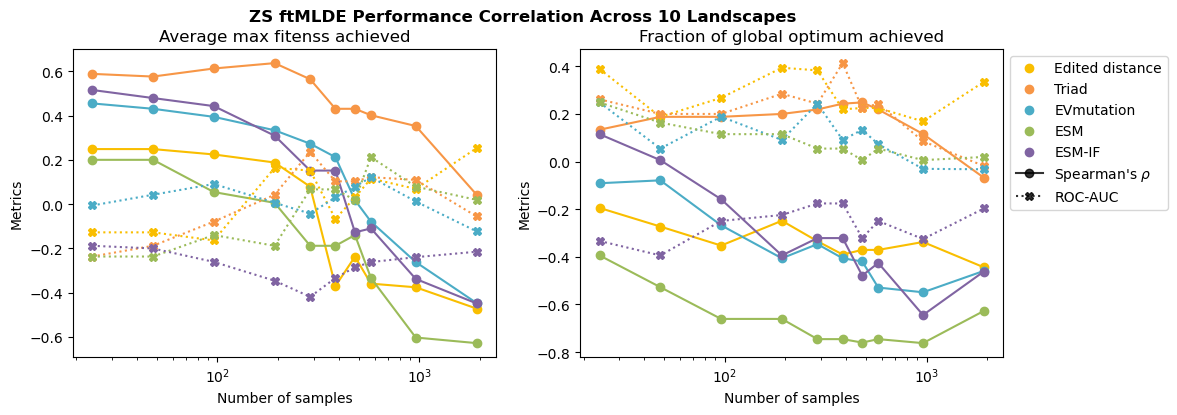

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, (ft_metric, v_ft) in enumerate(zs_ft_dict.items()):
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Number of samples")
    axes[i].set_ylabel("Metrics")
    axes[i].set_title(ft_metric_title[ft_metric])

    for zs_metric, v_zs in v_ft.items():
        
        for j, (zs, ys) in enumerate(v_zs.items()):
            axes[i].plot(N_SAMPLE_LIST, ys, label=zs, color=PRESENTATION_PALETTE_SATURATE[zs_color_list[j]], **zs_metric_style[zs_metric])


legend_list = []  # To store legend handles
for zs, lc in zip(zs_simple, zs_color_list):
    if zs == "double":
        l = "Edited distance"
    else:
        l = ZS_OPTS_LEGEND[zs+"_score"]
    legend_list.append(
        Line2D(
            [0],
            [0],
            marker="o",
            linestyle="none",
            color=PRESENTATION_PALETTE_SATURATE[lc],
            label=l,
        )
    )

for m in zs_metric_style.keys():
    legend_list.append(
        Line2D(
            [0],
            [0],
            color="black",
            alpha = 0.8,
            label=zs_metric_style_legend[m],
            **zs_metric_style[m]
        )
    )

axes[1].legend(handles=legend_list, loc="upper left", bbox_to_anchor=(1, 1))

fig.suptitle(
    "ZS ftMLDE Performance Correlation Across 10 Landscapes",
    fontsize=12,
    fontweight="bold",
    # y=0.975,
)